# ✅ Unzip Normalized Dataset

In [9]:
import zipfile

with zipfile.ZipFile("normalized_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")

print("✅ Normalized dataset is ready!")

✅ Normalized dataset is ready!


# 🧪 Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset paths (use resized 160×160 images for faster training)

In [3]:
data_path = "/content/normalized_dataset/curated_data"
img_size = 160   # smaller than default 224 to reduce training time
batch_size = 32

# 🔄 Data generators with ResNet50 preprocessing and validation split

In [4]:
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset="training",
    class_mode="categorical",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical",
    shuffle=False
)

Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.


# 🔧 ResNet50 base model (pretrained on ImageNet) with frozen weights for faster convergence

In [5]:
base_model = ResNet50(
    include_top=False,
    input_shape=(img_size, img_size, 3),
    weights="imagenet"
)
base_model.trainable = False  # freeze the convolutional base

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# 📐 Add custom classification head

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation="softmax")(x)  # adjust “3” to match your number of classes
model = Model(inputs=base_model.input, outputs=predictions)

# 🚀 Compile with a low learning rate for stable fine-tuning later if needed

In [7]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()  # optional: inspect number of parameters

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 🏋️‍♂️ Train only the top layers for a few epochs

In [8]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,                   # keep epochs small initially
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1463s 3s/step - accuracy: 0.4653 - loss: 1.5515 - val_accuracy: 0.7496 - val_loss: 0.5757
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1446s 3s/step - accuracy: 0.6680 - loss: 0.8033 - val_accuracy: 0.7043 - val_loss: 0.6150
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1392s 3s/step - accuracy: 0.7158 - loss: 0.6874 - val_accuracy: 0.7113 - val_loss: 0.6012
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1432s 3s/step - accuracy: 0.7450 - loss: 0.6213 - val_accuracy: 0.6616 - val_loss: 0.6816
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 1409s 3s/step - accuracy: 0.7526 - loss: 0.5760 - val_accuracy: 0.6917 - val_loss: 0.6233


# 💾 Save the optimized model

In [15]:
model.save("ResNet50_Optimized.h5")
print("✅ Model saved as ResNet50_Optimized.h5")

✅ Model saved as ResNet50_Optimized.h5


# 📉 Plot training history

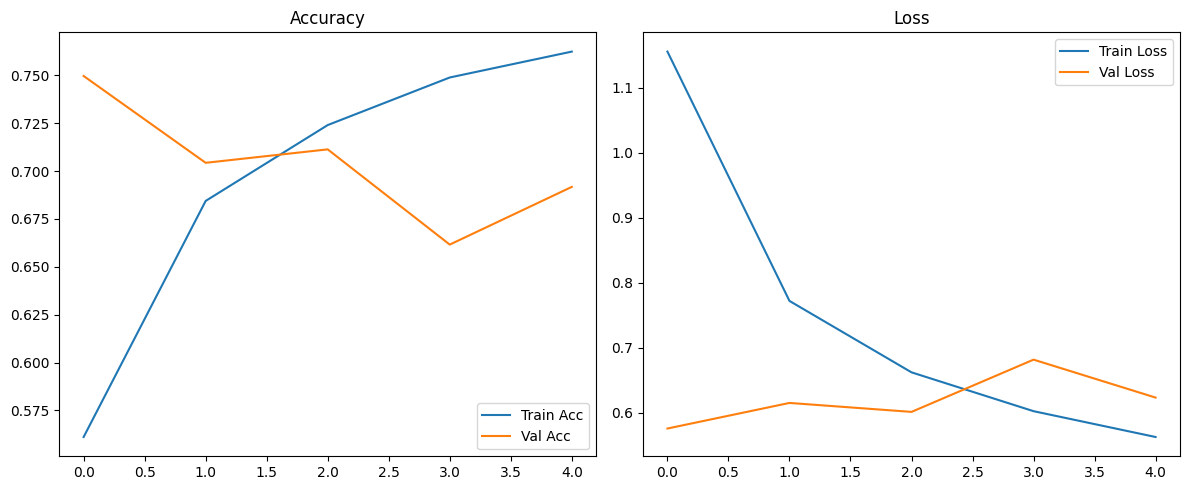

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()

# 📊 Evaluation on validation set

In [12]:
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

107/107 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.70      0.90      0.79      1378
      2COVID       0.74      0.49      0.59      1518
        3CAP       0.59      0.72      0.65       523

    accuracy                           0.69      3419
   macro avg       0.68      0.70      0.68      3419
weighted avg       0.70      0.69      0.68      3419



# 📉 Confusion matrix

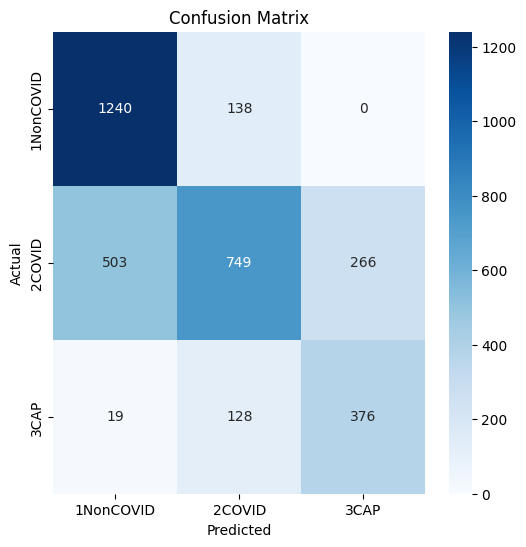

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Final accuracy & error rate

In [14]:
final_loss, final_acc = model.evaluate(val_data, verbose=0)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")

✅ Final Accuracy: 0.6917
❌ Error Rate: 30.83%
